In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers

import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import numpy as np

2025-10-07 18:26:19.592750: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/divyanshu/anaconda3/envs/venv/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


callback function

In [2]:
def callback_(filepath, monitor="val_loss", tensorboard=True, earlystop=3):
    callback_list = []

    callback_list.append(keras.callbacks.ModelCheckpoint(filepath,
                                                         save_best_only = True,
                                                         monitor=monitor
                                                         ))
    if tensorboard:
        log_dir = "tensorlog_" + filepath
        callback_list.append(keras.callbacks.TensorBoard(log_dir=log_dir))
    
    if earlystop>0:
        callback_list.append(keras.callbacks.EarlyStopping(patience=earlystop))

    return callback_list

Let's get and classify data first

In [3]:
data_dir = "cat_dog"

train_path = data_dir + "/train"
test_path = data_dir + "/test"
validation_path = data_dir + "/validation"

Visualise the original data

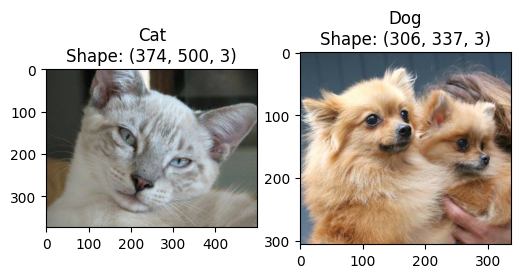

In [4]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

cat_image = train_path + '/cat/cat.69.jpg'
dog_image = train_path + '/dog/dog.77.jpg'

cat_img = imread(cat_image)
dog_img = imread(dog_image)

# Prepare list of (image array, title)
imgs = [
    (cat_img, f"Cat\nShape: {cat_img.shape}"),
    (dog_img, f"Dog\nShape: {dog_img.shape}")
]

plt.figure(figsize=(6,3))
for i, (img, title) in enumerate(imgs, 1):
    plt.subplot(1, 2, i)
    plt.imshow(img)
    plt.title(title)
plt.show()


So from above images it's quite clear that all the images have different dimensions. So plot the variations in dimension 

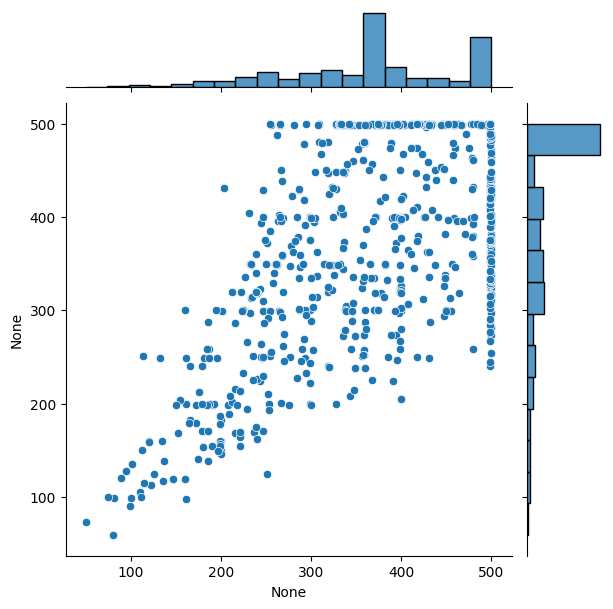

In [5]:
height = []
width = []

for image_file in os.listdir(train_path+'/dog'):
    image  = imread(train_path +'/dog/' + image_file)
    h,w,c = image.shape
    height.append(h)
    width.append(w)

sns.jointplot(x=height,y=width)

Now, we just have the images in folders. We need to make it into a workable dataset:
  * which has labels
  * all the images have the same size

In [6]:
from keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
                train_path,
                image_size=(180,180),
                batch_size=32
)
validation_dataset = image_dataset_from_directory(
                validation_path,
                image_size=(180,180),
                batch_size=32
)
test_dataset = image_dataset_from_directory(
                test_path,
                image_size=(180,180),
                batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


Verify batch size

In [7]:
for data_batch,labels_batch in train_dataset:
    print(f"image batch shape:{data_batch.shape}")
    print(f"label batch shape:{labels_batch.shape}")
    break


image batch shape:(32, 180, 180, 3)
label batch shape:(32,)


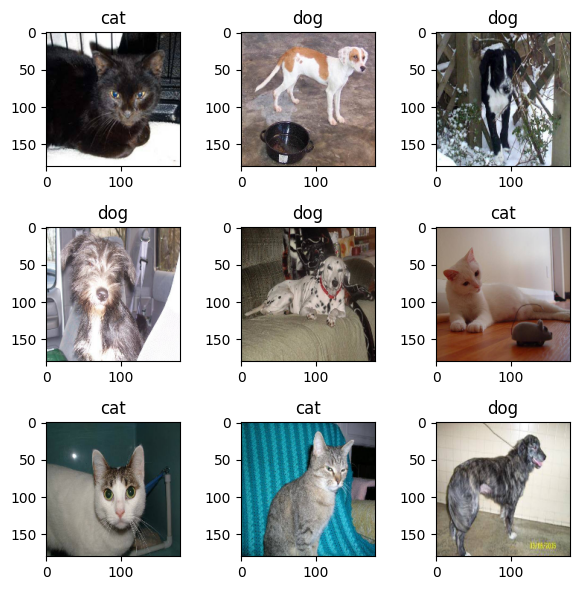

In [8]:
images = data_batch.numpy()
labels = labels_batch.numpy()

plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].astype("uint8"))  # convert float -> int for display
    plt.title("cat" if labels[i] == 0 else "dog")
plt.tight_layout()
plt.show()


Defining convet model

In [9]:
from keras import Input
from keras.layers import Rescaling,Conv2D,MaxPooling2D,Flatten,Dense

input = Input(shape=(180,180,3))
rescaling =  Rescaling(1./255,name="Rescaling")(input)
conv1 = Conv2D(filters=32, kernel_size=3,activation='relu',name= "Conv1")(rescaling)
maxpool1 = MaxPooling2D(pool_size=2, name = "Pool1")(conv1)
conv2 = Conv2D(filters=64, kernel_size=3,activation='relu',name= "Conv2")(maxpool1)
maxpool2 = MaxPooling2D(pool_size=2, name = "Pool2")(conv2)
conv3 = Conv2D(filters=128, kernel_size=3,activation='relu',name= "Conv3")(maxpool2)
maxpool3 = MaxPooling2D(pool_size=2, name = "Pool3")(conv3)
conv4 = Conv2D(filters=256, kernel_size=3,activation='relu',name= "Conv4")(maxpool3)
maxpool4 = MaxPooling2D(pool_size=2, name = "Pool4")(conv4)
conv5 = Conv2D(filters=256, kernel_size=3,activation='relu',name= "Conv5")(maxpool4)
flatten = Flatten(name="Flatten")(conv5)
output = Dense(1, activation=tf.nn.sigmoid)(flatten)

model = keras.Model(inputs= input, outputs = output)


In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2 (MaxPooling2D)            │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool3 (MaxPooling2D)            │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv4 (Conv2D)                  │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool4 (MaxPooling2D)            │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv5 (Conv2D)                  │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

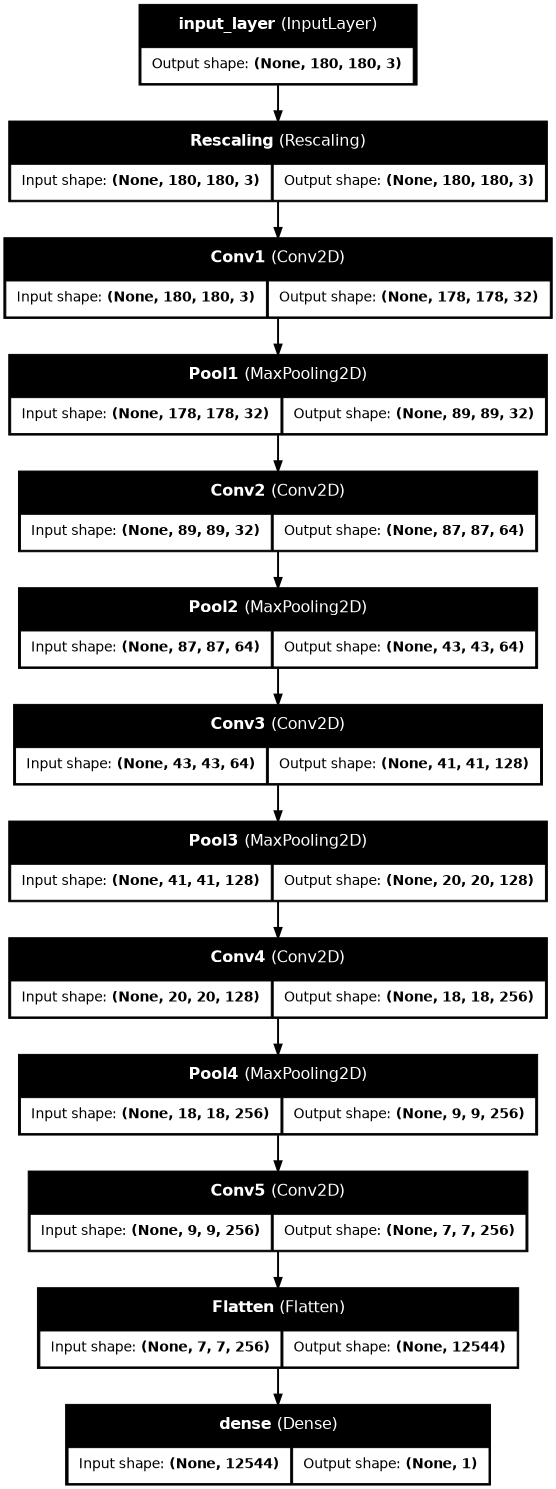

In [11]:
from keras.utils import plot_model
plot_model(model, dpi = 70, show_shapes=True,show_layer_names=True)

In [12]:
model.compile(loss='binary_crossentropy',
                    optimizer = 'Adam',
                    metrics = ['Accuracy'])

In [114]:
history = model.fit(
            train_dataset,
            epochs = 20,
            validation_data = validation_dataset,
            callbacks = callback_("cnn.keras")
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 555ms/step - Accuracy: 0.5305 - loss: 0.6913 - val_Accuracy: 0.6030 - val_loss: 0.6439
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 511ms/step - Accuracy: 0.5740 - loss: 0.6732 - val_Accuracy: 0.5670 - val_loss: 0.6695
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 505ms/step - Accuracy: 0.6110 - loss: 0.6580 - val_Accuracy: 0.6220 - val_loss: 0.6617
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 505ms/step - Accuracy: 0.6470 - loss: 0.6433 - val_Accuracy: 0.6120 - val_loss: 0.6385
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 529ms/step - Accuracy: 0.6975 - loss: 0.5898 - val_Accuracy: 0.6740 - val_loss: 0.5912
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 522ms/step - Accuracy: 0.7340 - loss: 0.5352 - val_Accuracy: 0.6840 - val_loss: 0.6243
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 508ms/step - Accuracy: 0.7455 - loss: 0.5046 - val_Accuracy: 0.6890 - val_loss: 0.6751
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 523ms/step - Accuracy: 0.7460 - loss: 0.5033 - val_Accu

In [13]:
test_model = keras.models.load_model("cnn.keras")

In [ ]:
test_loss,test_acc = model.evaluate(test_dataset)

63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step - Accuracy: 0.5135 - loss: 0.6929


In [15]:
class_names = test_dataset.class_names  # ['cat', 'dog']

for images, labels in test_dataset.take(1):
    sample_images = images[:3]
    sample_labels = labels[:3]


2025-10-07 18:27:08.802151: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


From just **2000** images, our network has learnt to classify images of cats and dogs with an accuracy of apx **70%**

In [16]:
predictions = model.predict(sample_images)
predicted_classes = tf.argmax(predictions, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


In [17]:
predicted_classes = (predictions > 0.5).astype("int32").flatten()

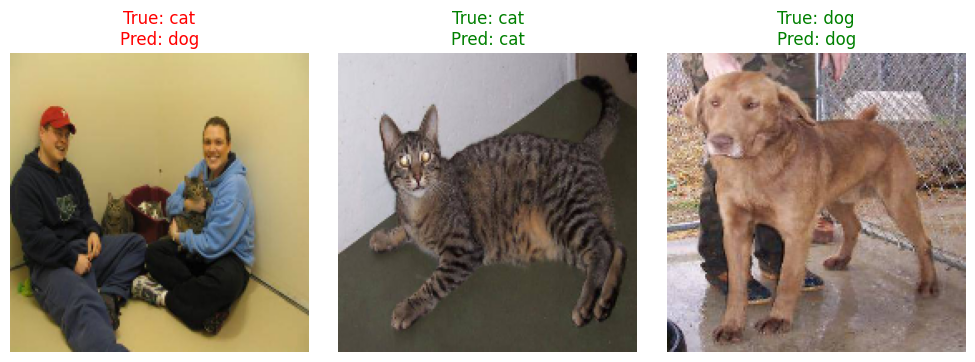

In [158]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(3):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(sample_images[i].numpy().astype("uint8"))
    true_label = class_names[sample_labels[i]]
    pred_label = class_names[predicted_classes[i]]
    color = "green" if true_label == pred_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis("off")
plt.tight_layout()
plt.show()

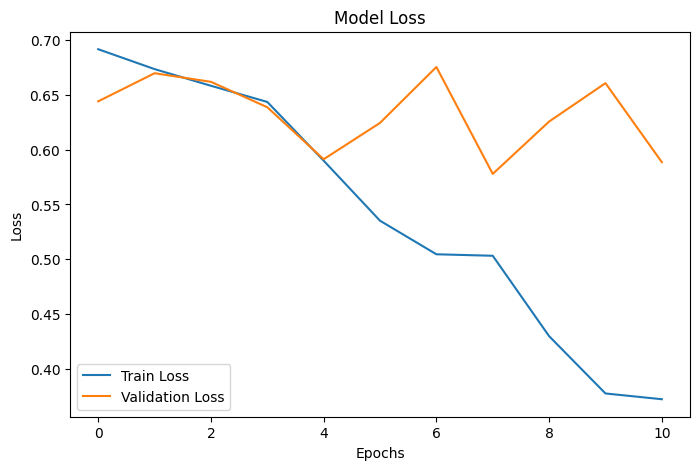

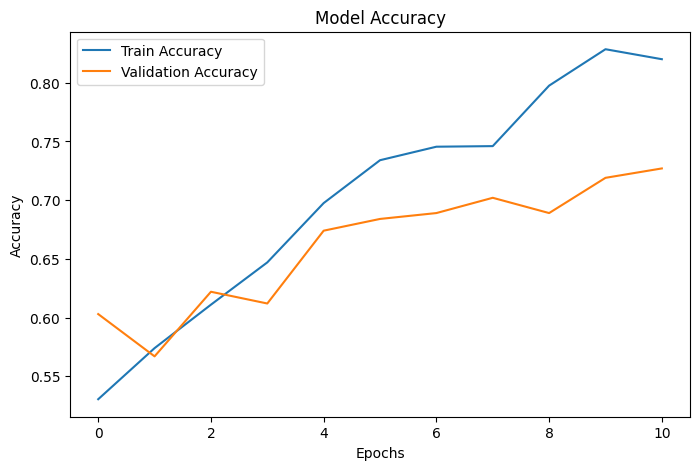

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy Graph
plt.figure(figsize=(8,5))
plt.plot(history.history['Accuracy'], label='Train Accuracy')
plt.plot(history.history['val_Accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Now we can see that our data set is too small. That's why we need to do some data augmentation!!

In [20]:
def get_data_augmented(flip='horizontal', rotation=0.1, zoom=0.2):
    data_augmentation = keras.Sequential([
        keras.layers.RandomFlip(flip),
        keras.layers.RandomRotation(rotation),
        keras.layers.RandomZoom(zoom)
    ])
    return data_augmentation

augment_data = get_data_augmented()

In [32]:
input = Input(shape=(180,180,3))

data_augmentation = augment_data(input)
rescaling =  Rescaling(1./255,name="Rescaling")(data_augmentation)
conv1 = Conv2D(filters=32, kernel_size=3,activation='relu',name= "Conv1")(rescaling)
maxpool1 = MaxPooling2D(pool_size=2, name = "Pool1")(conv1)
conv2 = Conv2D(filters=64, kernel_size=3,activation='relu',name= "Conv2")(maxpool1)
maxpool2 = MaxPooling2D(pool_size=2, name = "Pool2")(conv2)
conv3 = Conv2D(filters=128, kernel_size=3,activation='relu',name= "Conv3")(maxpool2)
maxpool3 = MaxPooling2D(pool_size=2, name = "Pool3")(conv3)
conv4 = Conv2D(filters=256, kernel_size=3,activation='relu',name= "Conv4")(maxpool3)
maxpool4 = MaxPooling2D(pool_size=2, name = "Pool4")(conv4)
conv5 = Conv2D(filters=256, kernel_size=3,activation='relu',name= "Conv5")(maxpool4)
flatten = Flatten(name="Flatten")(conv5)
output = Dense(1, activation=tf.nn.sigmoid)(flatten)

model = keras.Model(inputs= input, outputs = output)


In [33]:
model.compile(loss='binary_crossentropy',
                        optimizer='Adam',
                        metrics=['Accuracy'])

In [35]:
history = model.fit(train_dataset,
                    epochs=80,
                    validation_data = validation_dataset,
                    callbacks=callback_("cnn.keras"))

Epoch 1/80
15/63 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - Accuracy: 0.5371 - loss: 0.7105

KeyboardInterrupt: 